In [351]:
from dm_control import mjcf,mujoco
import PIL.Image

In [352]:
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

%matplotlib inline

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython import display
import PIL.Image

from tempfile import NamedTemporaryFile
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    video=anim.to_html5_video()

    html = display.HTML(video) 
  
    # draw the animation 
    display.display(html)

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

In [553]:
sort_task=mjcf.RootElement(model='sort_task')
sort_task.compiler.angle="radian"
sort_task.compiler.autolimits="true"

sort_task.visual.headlight.diffuse="0.6 0.6 0.6"
sort_task.visual.headlight.ambient="0.1 0.1 0.1"
sort_task.visual.headlight.specular="0 0 0"
sort_task.visual.__getattr__('global').azimuth="0"
sort_task.visual.__getattr__('global').elevation="-30"
sort_task.visual.__getattr__('global').offwidth="1000"
sort_task.visual.__getattr__('global').offheight="1000"
sort_task.visual.quality.shadowsize="4096"

light_wood_texture=sort_task.asset.add('texture',file='/home/vignesh/robot-collab_vig/rocobench/envs/assets/objects/textures/light-wood.png',type="2d",name='tex-light-wood')
light_wood=sort_task.asset.add('material',name='light-wood',reflectance=0.2,texrepeat="15 15",texture='tex-light-wood',texuniform='true')
chequered = sort_task.asset.add('texture', type='2d', builtin='checker', width=300, height=300, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
groundplane = sort_task.asset.add('material', name='grid', texture=chequered, texrepeat=[2, 2], reflectance=.2)

In [554]:
sort_task.worldbody.add('light',pos="0 0 1.5",dir="0 0 -1",directional="true")
sort_task.worldbody.add('geom',name="floor",pos="0 0 -0.5",size="0 0 0.05", type="plane",material=groundplane)
#panda=mjcf.from_path('/home/vignesh/robot-collab_vig/rocobench/envs/assets/panda/panda.xml')
#sort_task.worldbody.attach(panda)
table_body=sort_task.worldbody.add('body',name='table',pos='0 0.5 0')
table_body.add('geom',name='table_collision',pos='0 0 0.1',size='1.6 0.4 0.05', type='box', group='0', friction='1 0.5 0.0001',rgba='1 1 1 1')

table_top_body=table_body.add('body',name='table_top',pos='0 0 0.1')
table_top_body.add('geom',name='table_top',size='1.6 0.4 0.05',type='box',conaffinity='0',contype='0', group='1',rgba='1 1 1 1')

robot1_site=sort_task.worldbody.add('site',name='robot1',pos='-0.5 -0.05 0.1')
robot2_site=sort_task.worldbody.add('site',name='robot2',pos='0.5 1.05 0.1',euler='0 0 3.14159')
robot3_site=sort_task.worldbody.add('site',name='robot3',pos='-0.5 1.05 0.1')#,euler='0 0 3.14159')
robot1=mjcf.from_path('/home/vignesh/robot-collab_vig/rocobench/envs/assets/panda/panda.xml')
robot1.model='panda1'
#robot2=mjcf.from_path('/home/vignesh/robot-collab_vig/rocobench/envs/assets/panda/panda.xml')
#robot2.model='ur5e'

robot3=mjcf.from_path('/home/vignesh/robot-collab_vig/rocobench/envs/assets/ur5e_robotiq/ur5e_robotiq_full.xml')
robot3.model='ur5e'

robot1_site.attach(robot1)
#robot2_site.attach(robot2)
robot3_site.attach(robot3)
#table_body.add('geom',name='table_left',pos='-1.63 0 1', size='0.02 1.6 1.5', rgba='1 1 1 0', type='box')
#table_body.add('geom',name='table_right',pos='1.63 0 1', size='0.02 1.6 1.5', rgba='1 1 1 0', type='box')
#table_body.add('geom',name='table_front',pos='0 1.63 1', size='1.7 0.02 1.5', rgba='1 1 1 0', type='box')
#table_body.add('geom',name='table_back',pos='0 -1.63 1', size='1.7 0.02 1.5', rgba='1 1 1 0', type='box')

sort_task.worldbody.add('camera', mode="fixed", name='face_panda1', pos="0.062 -2.806 0.768", xyaxes="1.000 0.009 -0.000 0.001 -0.131 0.991")
sort_task.worldbody.add('camera', mode="fixed", name='face_panda2', pos="0.084 3.711 0.772", xyaxes="-1.000 0.016 0.000 0.002 0.111 0.994")
sort_task.worldbody.add('camera', mode="fixed", name='top_cam', pos="-0.001 0.652 2.057", xyaxes="-1.000 -0.000 -0.000 0.000 -1.000 0.019")
sort_task.worldbody.add('camera', mode="fixed", name='right_cam', pos="1.873 0.605 0.926", xyaxes="0.014 1.000 0.000 -0.242 0.003 0.970")
sort_task.worldbody.add('camera', mode="fixed", name='left_cam', pos="-1.873 0.605 0.926", xyaxes="-0.000 -1.000 0.000 0.177 -0.000 0.984")
sort_task.worldbody.add('camera', name='teaser', pos="2.675 -0.747 1.997", xyaxes="0.496 0.869 -0.000 -0.429 0.245 0.869")
sort_task.worldbody.add('camera', name='video', pos="1.957 -0.281 1.731", xyaxes="0.487 0.874 0.000 -0.500 0.278 0.820")

MJCF Element: <camera name="video" class="/" pos="1.9570000000000001 -0.28100000000000003 1.7310000000000001" xyaxes="0.48699999999999999 0.874 0 -0.5 0.27800000000000002 0.81999999999999995"/>

In [555]:
bin_body1=table_top_body.add('body',name='bin1',pos='-0.5 0 0.05')
bin_body1.add('geom',name='bottom1',type='box',size='0.35 0.2 0.02',friction="1 0.005 0.0001",material='light-wood')
# bin_body1.add('geom',name='front1',type='box',pos='0 0.2 0.1',size='0.35 0.02 0.06',friction="1 0.005 0.0001",material='light-wood')
# bin_body1.add('geom',name='back1',type='box',pos='0 -0.2 0.1',size='0.35 0.02 0.06',friction="1 0.005 0.0001",material='light-wood')
# bin_body1.add('geom',name='right1',type='box',pos='0.35 0 0.1',size='0.02 0.2 0.06',friction="1 0.005 0.0001",material='light-wood')
# bin_body1.add('geom',name='left1',type='box',pos='-0.35 0 0.1',size='0.02 0.2 0.06',friction="1 0.005 0.0001",material='light-wood')

box=sort_task.worldbody.add('body',name='black_box',pos='-0.5 0.5 0.1')
box.add('joint',type='free',name='box_free')
box.add('body',name='box_top',pos='0 0 0.03')
box.add('body',name='box_bottom',pos='0 0 -0.03')
box.add('site',name='box_top',type='sphere',pos='0 0 0.03')
box.add('site',name='box_bottom',type='sphere',pos='0 0 -0.03')
box.add('geom',name='box_collision',type='box',size='0.03 0.03 0.03',rgba='0 0 0 1')

bin_body2=table_top_body.add('body',name='bin2',pos='0.5 0 0.05')
bin_body2.add('geom',name='bottom2',type='box',size='0.35 0.2 0.02',friction="1 0.005 0.0001",material='light-wood')
# bin_body2.add('geom',name='front2',type='box',pos='0 0.2 0.1',size='0.35 0.02 0.06',friction="1 0.005 0.0001",material='light-wood')
# bin_body2.add('geom',name='back2',type='box',pos='0 -0.2 0.1',size='0.35 0.02 0.06',friction="1 0.005 0.0001",material='light-wood')
# bin_body2.add('geom',name='right2',type='box',pos='0.35 0 0.1',size='0.02 0.2 0.06',friction="1 0.005 0.0001",material='light-wood')
# bin_body2.add('geom',name='left2',type='box',pos='-0.35 0 0.1',size='0.02 0.2 0.06',friction="1 0.005 0.0001",material='light-wood')
#bin_body=sort_task.worldbody.add('body', name="bin", pos="0.45 0.5 0.16")
#bin_inside_body=bin_body.add('body', name="bin_inside", pos="0 0 0")
#bin_inside_body.add('geom', name="bin_inside_bottom", pos="0 0 0", size="0.35 0.2 0.02", type="box", group="3", friction="1 0.005 0.0001", material="light-wood")
#bin_inside_body.add('geom', name="bin_inside_front", pos="0 0.2 0.03", size="0.35 0.01 0.06", type="box", group="3", friction="1 0.005 0.0001", material="light-wood")
#bin_inside_body.add('geom', name="bin_inside_back", pos="0 -0.2 0.03", size="0.35 0.01 0.06", type="box", group="3", friction="1 0.005 0.0001", material="light-wood")
#bin_inside_body.add('geom', name="bin_inside_right", pos="0.38 0 0.03", size="0.01 0.18 0.06", type="box", group="3", friction="1 0.005 0.0001", rgba="1 0 0 0")
#bin_inside_body.add('geom', name="bin_inside_left", pos="-0.38 0 0.03", size="0.01 0.18 0.06", type="box", group="3", friction="1 0.005 0.0001", rgba="1 0 0 0" )

#bin_body.add('geom', name="bin_right", pos="0.35 0 0.03", size="0.01 0.2 0.06", type="box", group="3", friction="1 0.005 0.0001", material="light-wood", margin="0.01")
#bin_body.add('geom', name="bin_left", pos="-0.35 0 0.03", size="0.01 0.2 0.06", type="box", group="3", friction="1 0.005 0.0001", material="light-wood", margin="0.01")

MJCF Element: <geom name="bottom2" class="/" type="box" size="0.34999999999999998 0.20000000000000001 0.02" material="light-wood" friction="1 0.0050000000000000001 0.0001"/>

In [556]:
#sort_task.contact.add('pair', name="milk_panda", geom1="panda1/panda_hand_collision", geom2="box_collision", margin="0.05")
sort_task.equality.add('weld',name='panda1_top',body1='box_top',body2='panda1/panda_palm',relpose='0 0 0 1 0 0 0',active='false')
sort_task.equality.add('weld',name='panda1_bottom',body1='box_bottom',body2='panda1/panda_palm',relpose='0 0 0 1 0 0 0',active='false')

sort_task.equality.add('weld',name='ur5e_top',body1='box_top',body2='ur5e/robotiq_tip',relpose='0 0 0 1 0 0 0',active='false')
sort_task.equality.add('weld',name='ur5e_bottom',body1='box_bottom',body2='ur5e/robotiq_tip',relpose='0 0 0 1 0 0 0',active='false')
#sort_task.equality.add('weld',name='ur5e_top',body1='box_top',body2='ur5e/panda_palm',relpose='0 0 0 1 0 0 0',active='false')
#sort_task.equality.add('weld',name='ur5e_bottom',body1='box_bottom',body2='ur5e/panda_palm',relpose='0 0 0 1 0 0 0',active='false')
panda_qpos0='0 0 0 0 -1.57079 0 1.57079 -0.7853 0.04 0.04'
ur5_qpos0='0 -1.5708 -1.5708 1.5708 -1.5708 -1.5708 0 0 0 0 0 0 0 0 0'
box_qpos0='-0.5 0.5 0.22 0 0 0 0'
panda_ctrl0='0 0 0 0 -1.57079 0 1.57079 -0.7853 255'
ur5_ctrl0='0 1.5708 -1.5708 1.5708 -1.5708 -1.5708 0 0'
sort_task.keyframe.add('key',name='home',qpos=panda_qpos0+' '+ur5_qpos0+' '+box_qpos0, ctrl=panda_ctrl0+' '+ur5_ctrl0)

MJCF Element: <key name="home" qpos="0 0 0 0 -1.5707899999999999 0 1.5707899999999999 -0.7853 0.040000000000000001 0.040000000000000001 0 -1.5708 -1.5708 1.5708 -1.5708 -1.5708 0 0 0 0 0 0 0 0 0 -0.5 0.5 0.22 0 0 0 0" ctrl="0 0 0 0 -1.5707899999999999 0 1.5707899999999999 -0.7853 255 0 1.5708 -1.5708 1.5708 -1.5708 -1.5708 0 0"/>

In [557]:
print(sort_task.to_xml_string())
f = open("task_handover.xml", "w")
f.write(sort_task.to_xml_string())
f.close()


<mujoco model="sort_task">
  <compiler autolimits="true" angle="radian"/>
  <option integrator="implicit"/>
  <visual>
    <global azimuth="0" elevation="-30" offwidth="1000" offheight="1000"/>
    <quality shadowsize="4096"/>
    <headlight ambient="0.10000000000000001 0.10000000000000001 0.10000000000000001" diffuse="0.59999999999999998 0.59999999999999998 0.59999999999999998" specular="0 0 0"/>
  </visual>
  <default>
    <default class="/"/>
    <default class="panda1/">
      <default class="panda1/panda">
        <material specular="0.5" shininess="0.25"/>
        <joint axis="0 0 1" range="-2.8973 2.8973" armature="0.10000000000000001" damping="15"/>
        <general ctrlrange="-2.8973 2.8973" forcerange="-87 87" dyntype="none" biastype="affine"/>
        <default class="panda1/finger">
          <joint type="slide" axis="0 1 0" range="0 0.040000000000000001"/>
        </default>
        <default class="panda1/visual">
          <geom type="mesh" contype="0" conaffinity="0" grou

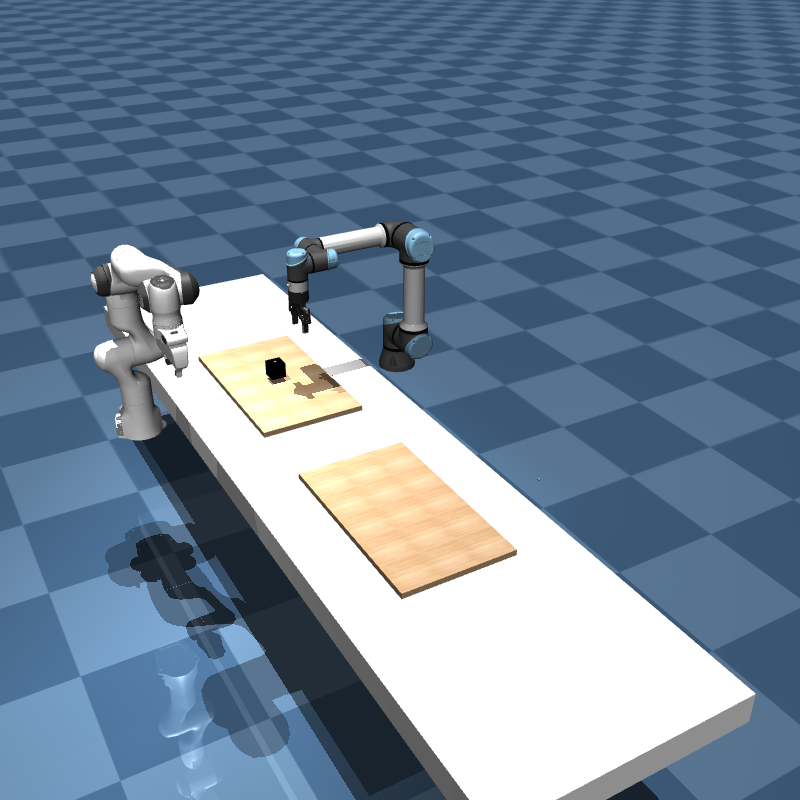

In [558]:
physics=mjcf.Physics.from_mjcf_model(sort_task)
physics.reset(0)
#final_physics=mjcf.from_path('/home/vignesh/robot-collab_vig/rocobench/envs/assets/ur5e/ur5e_robotiq_full.xml')
pixels=physics.render(width=800,height=800,camera_id=5)

ctrl_shape=physics.data.ctrl.shape
PIL.Image.fromarray(pixels)
#print(physics.named.data.qpos)
#print(physics.data.qvel.shape)



In [463]:
%reload_ext autoreload
%autoreload 2
from dm_control import mujoco,viewer

from rocobench import PlannedPathPolicy, LLMPathPlan, MultiArmRRT
from rocobench.envs import SimRobot
from rocobench import PlannedPathPolicy, LLMPathPlan, MultiArmRRT
from rocobench.envs.constants import PANDA_CONSTANTS as pc
from rocobench.envs.constants import UR5E_ROBOTIQ_CONSTANTS as pc
import copy
from rocobench.subtask_plan import LLMPathPlan
from rocobench.envs.env_utils import Pose



In [465]:
target_body='black_box'
target_body_top='box_top'
target_body_bottom='box_bottom'

def home_pose(physics,robots):
    # for key,value in robots.items:
    #     continue
    # qpos0=[0., 0., 0., -1.57079, 0, 1.57079, -0.7853,0]
    # ctrl0=[0, 0, 0, -1.57079, 0, 1.57079, -0.7853,0]
    # qpos=physics.data.qpos.copy()
    # qpos[panda1.joint_idxs_in_qpos]=np.array(qpos0)
    # qpos[ur5e.joint_idxs_in_qpos]=np.array(qpos0)
    # with physics.reset_context():
    #     physics.data.qpos=qpos
    #     physics.data.qvel=np.zeros_like(physics.data.qvel)
    #     physics.data.ctrl[panda1.joint_idxs_in_ctrl]=ctrl0
    #     physics.data.ctrl[panda2.joint_idxs_in_ctrl]=ctrl0
    #     physics.step()
    # return physics
    
    physics.reset(0)
    return physics

def append_panda_names(name,panda_constants):
    constants = dict()
    constants["name"] = name
    for key, value in panda_constants.items():
        #print(key)
        if (key=='name') :
            continue
        if key == "actuator_info":
            constants[key] = {name + "/" + x: name + "/" + y for x, y in value.items()}
        elif isinstance(panda_constants[key],str):
            constants[key]=name+'/'+value
        else:
            constants[key] = [name + "/" + x for x in value]

    return constants

def append_ur5e_names(name,ur5e_constants):
    constants = dict()
    constants["name"] = name
    for key, value in ur5e_constants.items():
        #print(key)
        if (key=='name') :
            continue
        if key == "actuator_info":
            constants[key] = {name + "/" + x: name + "/" + y for x, y in value.items()}
        elif isinstance(ur5e_constants[key],str):
            constants[key]=name+'/'+value
        else:
            constants[key] = [name + "/" + x for x in value]

    return constants

ur5e_constants = append_panda_names("ur5e",UR5E_ROBOTIQ_CONSTANTS)

ur5e=SimRobot(physics=physics,use_ee_rest_quat=False,**ur5e_constants)
panda1_constants = append_panda_names("panda1",PANDA_CONSTANTS)
panda2_constants = append_panda_names("ur5e",PANDA_CONSTANTS)

panda1=SimRobot(physics=physics,use_ee_rest_quat=False,**panda1_constants)
#panda2=SimRobot(physics=physics,use_ee_rest_quat=False,**panda2_constants)
robots={'panda1':panda1,'ur5e':ur5e}
print(panda1.joint_idxs_in_ctrl)

[1, 2, 3, 4, 5, 6, 7, 0]


In [29]:
target_pose1=np.array([-0.5,0,0])
target_pose=np.array([-0.5,0.1,0])
target_pose1[2]+=0.1
print(target_pose1)
target_pose2=target_pose.copy()

target_pose2[0]=-1*target_pose2[0]
target_pose2[2]=0.5
print(target_pose1)
print(target_pose2)
#physics.named.data.xmat[target_body_top]
target_quat=np.array([ 0, 1, 0, 0.0])
result1=panda1.solve_ik(physics,target_pos=target_pose,target_quat=target_quat)
result2=panda2.solve_ik(physics,target_pos=target_pose2)
ctrl1=panda1.map_qpos_to_joint_ctrl(result1.qpos)
ctrl2=panda1.map_qpos_to_joint_ctrl(result2.qpos)
#ctrl2=np.random.random(7)
print(result1.qpos)
print(ctrl1)

[-0.5  0.   0.1]
[-0.5  0.   0.1]
[0.5 0.1 0.5]
[ 1.61891336  4.1407995   0.01180247  1.75006743  0.01454794  2.3906476
  2.38729096  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.5         0.5         0.4         1.          0.          0.
  0.        ]
{'ctrl_idxs': [0, 1, 2, 3, 4, 5, 6], 'ctrl_vals': array([1.61891336, 4.1407995 , 0.01180247, 1.75006743, 0.01454794,
       2.3906476 , 2.38729096])}


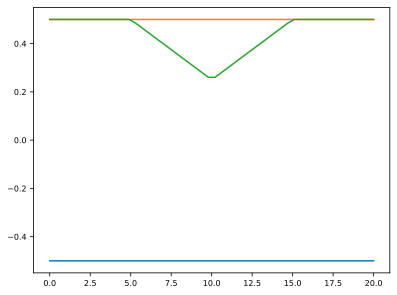

In [75]:
def traj(t):
  #t+=15
  if t<5:
    return np.array([-0.5,0.5,0.5])
  elif t>=5 and t<=10:
    return np.array([-0.5,0.5,0.5*(2-t/5)+0.25*(t/5-1)])
  elif t>10 and t<=15:
    return np.array([-0.5,0.5,0.25*(3-t/5)+0.5*(2*t/10-2)])
  else:
    return np.array([-0.5,0.5,0.5])
ts=np.linspace(0,20)
ys=[traj(t) for t in ts]
plt.plot(ts,ys)

In [217]:
frames = []
ctrls=[]
duration=5
framerate=20
control_rate=0.1
physics.reset()  # Reset state and time

while physics.data.time < duration:
  #target_pose=physics.named.data.xpos[target_body_top]
  #result=panda1.solve_ik(physics,target_pos=target_pose)
  #ctrl=panda1.map_qpos_to_joint_ctrl(result.qpos)
  t0=physics.data.time
  target_pose=traj(physics.data.time)
  #print(target_pose)
  result1=panda1.solve_ik(physics,target_pos=target_pose,target_quat=target_quat)
  result2=panda2.solve_ik(physics,target_pos=np.array([0.5,0.5,0.3]))
  ctrl1=panda1.map_qpos_to_joint_ctrl(result1.qpos)
  ctrl2=panda1.map_qpos_to_joint_ctrl(result2.qpos)
  ctrl=np.concatenate((ctrl1['ctrl_vals'],[0],ctrl2['ctrl_vals'],[0]))
  physics.data.ctrl=ctrl
  #print(ctrl)
  while physics.data.time-t0<0.1:
  #print(physics.data.ctrl)
    physics.step()
    if len(frames) < physics.data.time * framerate:
      pixels = physics.render(width=800,height=800)
      frames.append(pixels)
display_video(frames, framerate)

AttributeError: 'NoneType' object has no attribute 'qpos'

Loading...:   0%|          | 0/1 [00:00<?, ?it/s]

[array([-0.08187176,  0.38653017,  0.0567788 ])]


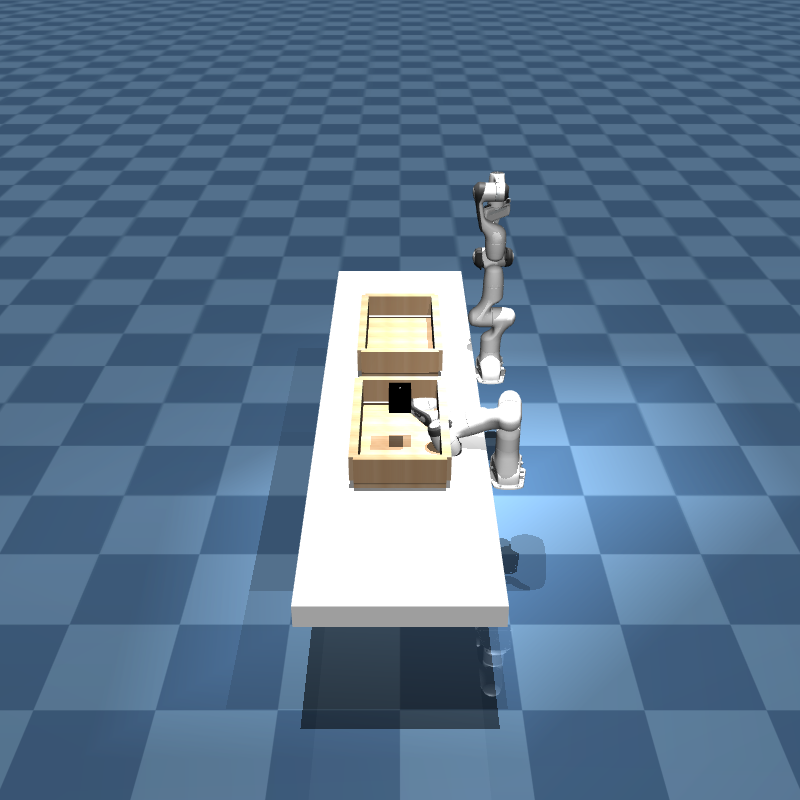

In [57]:
from tqdm import tqdm
physics.reset() 
# state=np.concatenate((result1.qpos,np.zeros(18)))
# with physics.reset_context():
#     physics.data.qpos=result1.qpos
#     physics.data.qvel=np.zeros_like(result1.qpos)
#     physics.step()
#     pixels=physics.render(width=800,height=800)

# ctrl_shape=physics.data.ctrl.shape
# print(np.linalg.norm(physics.named.data.site_xpos['panda1/ee']-target_pose))
# #PIL.Image.fromarray(pixels)

target_poses=[]
dists=[]
for i in tqdm (range (1), desc="Loading..."):
    
    target_pose=np.array([np.random.uniform(-0.7,-0.3),np.random.uniform(0.1,0.9),np.random.uniform(0,0.5)])
    target_poses.append(target_pose)
    target_quat=np.array([ 0, 1, 0, 0.0])
    result1=panda1.solve_ik(physics,target_pos=target_pose,target_quat=target_quat)
    if result1 is not None:
        physics.data.qpos=result1.qpos
        physics.data.qvel=np.zeros_like(physics.data.qvel)
        physics.step()
        dists.append(np.linalg.norm(physics.named.data.site_xpos['panda1/ee']-target_pose))
        pixels=physics.render(width=800,height=800)
        
        break
    else:
        dists.append(-1)
print(target_poses)
PIL.Image.fromarray(pixels)

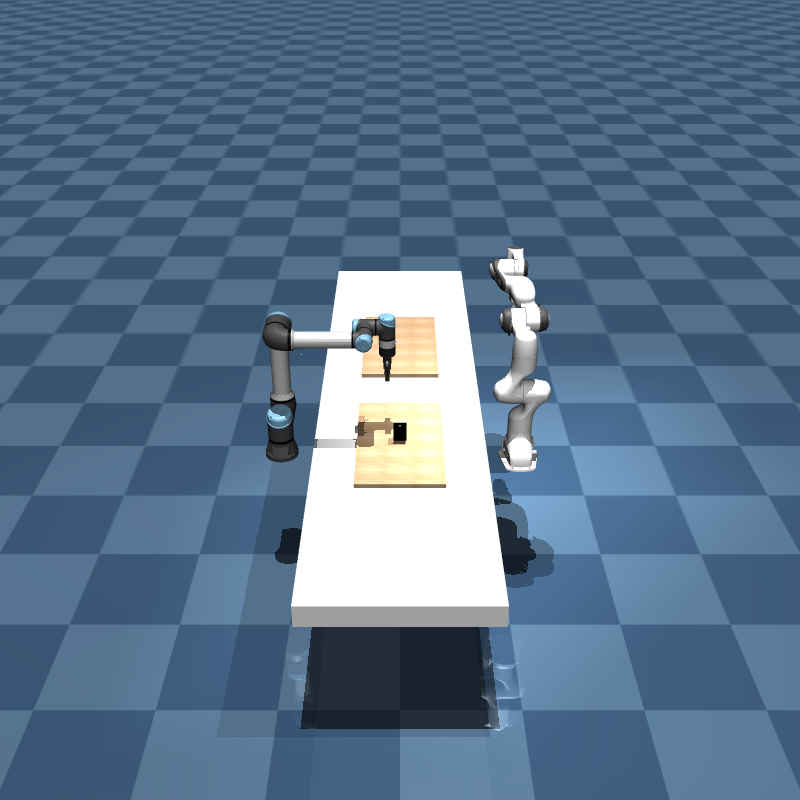

In [487]:

physics.reset(0)
physics=home_pose(physics,robots)
pixels=physics.render(width=800,height=800)
PIL.Image.fromarray(pixels) 

{'panda1': Pose(pos=(0.50,0.50,0.50),rot=(3.14,-0.00,0.00)), 'ur5e': Pose(pos=(-0.50,0.50,0.50),rot=(0.00,-0.00,3.14))}
{'panda1': (array([ 0.644818  ,  0.43834063,  0.37218651, -1.57706034, -0.16929885,
        1.9834506 ,  1.83842674,  0.60934804]), [1, 2, 3, 4, 5, 6, 7, 0]), 'ur5e': (array([-1.22220656, -1.21929931,  1.06876921, -1.42026622, -1.57079633,
       -1.22220656, -0.34246228]), [11, 12, 13, 14, 15, 16, 10])}
[ 0.60934804  0.644818    0.43834063  0.37218651 -1.57706034 -0.16929885
  1.9834506   1.83842674  0.04        0.04       -0.34246228 -1.22220656
 -1.21929931  1.06876921 -1.42026622 -1.57079633 -1.22220656  0.
  0.          0.          0.          0.          0.          0.
  0.         -0.5         0.5         0.22        1.          0.
  0.          0.        ]


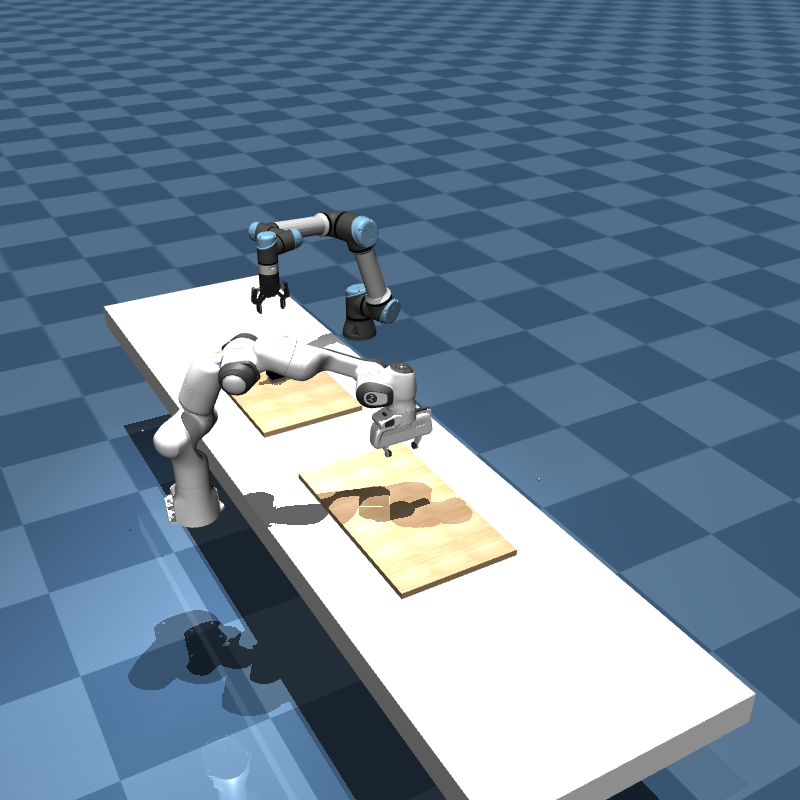

In [593]:
physics.reset(0)
planner=MultiArmRRT(physics,robots,graspable_object_names=['black_box'])
#target_ee1=Pose(np.array([ 0.05453773, -0.20000233,  0.52447919]),np.array([ 0, 1, 0, 0]))
#target_ee2=Pose(np.array([ 1.05453773, -0.20000233,  0.52447919]),np.array([ 0, 1, 0, 0]))
def get_q(theta):
    theta=theta*np.pi/180
    return np.array([0,np.sin(theta/2),0,np.cos(theta/2)])
target_ee1=Pose(np.array([ 0.5, 0.5,  0.5]),get_q(180))
target_ee2=Pose(np.array([ -0.5, 0.5,  0.5]),get_q(0))
#target_ee
ee_poses={}
ee_poses['panda1']=target_ee1
ee_poses['ur5e']=target_ee2
print(ee_poses)
result=planner.inverse_kinematics_all(physics,ee_poses)
print(result)
qpos=physics.data.qpos.copy()
qpos[result['panda1'][1]]=result['panda1'][0]
qpos[result['ur5e'][1]]=result['ur5e'][0]
print(qpos)
with physics.reset_context():
    physics.data.qpos=qpos
    physics.data.qvel=np.zeros_like(physics.data.qvel)
    physics.step()
    pixels=physics.render(width=800,height=800,camera_id=5)
PIL.Image.fromarray(pixels)
#planner.

In [559]:
physics=home_pose(physics,robots)
goal_qposs=[physics.data.qpos.copy()]

In [594]:
goal_qposs.append(qpos)

In [104]:
del goal_qposs[3]

In [577]:
print(len(goal_qposs))
i=3
qpos=goal_qposs[i]
with physics.reset_context():
    physics.data.qpos=qpos
    physics.data.qvel=np.zeros_like(physics.data.qvel)
    physics.step()
    pixels=physics.render(width=800,height=800,camera_id=5)
PIL.Image.fromarray(pixels)

3


IndexError: list index out of range

In [605]:
eq_ids=[0]
physics.reset()
physics=home_pose(physics,robots)
#print(planner.allow_collision_pairs(physics))
#np.concatenate((result['panda1'][0],result['panda2'][0]))
goal_qpos=physics.data.qpos.copy()
goal_qpos[result['panda1'][1]]=result['panda1'][0]
goal_qpos[result['ur5e'][1]]=result['ur5e'][0]
paths_list=[]
for i in range(len(goal_qposs)-1):
    print(i)
    paths=planner.plan(goal_qposs[i],goal_qposs[i+1],allow_grasp=True,)
    #print(paths)
    eq_ids.append(len(paths[0])+eq_ids[-1])
    paths_list+=paths[0]
    
eq_ids.append(eq_ids[-1])

print(eq_ids)

0
1
2
3
4
5
6
[0, 218, 295, 339, 375, 578, 781, 850, 850]


In [612]:
actions=[([0,3],[0,0]),([0,3],[0,0]),([0,3],[0,1]),([0,3],[0,1]),([0,3],[0,1]),([0,3],[1,0]),([0,3],[1,0]),([0,3],[1,0]),([0,3],[0,0])]
print(eq_ids)
idx=eq_ids[7]
qpos_full=physics.data.qpos.copy()
    #print(qpos_full.shape)
qpos_full[panda1.joint_idxs_in_qpos]=paths_list[idx][0:8]
qpos_full[ur5e.joint_idxs_in_qpos]=paths_list[idx][8:16]
with physics.reset_context():
    physics.data.qpos=qpos_full
    physics.data.qvel=np.zeros_like(physics.data.qvel)
    physics.step()
    pixels=physics.render(width=800,height=800,camera_id=5)
PIL.Image.fromarray(pixels)

[0, 218, 295, 339, 375, 578, 781, 850, 850]


IndexError: list index out of range

In [615]:
frames = []
ctrls=[]
duration=20
framerate=20
control_rate=0.02
physics.reset(0)  # Reset state and time
physics=home_pose(physics,robots)
physics.model.eq_active[0:4]=0
physics.model.eq_active[4:8]=1

print(physics.named.model.eq_active)
#physics.model.eq_active[0:4]=0
action_id=0
while physics.data.time < duration:
# for path in paths:
    idx = int(physics.data.time/ control_rate)
    if idx>=eq_ids[action_id]:
        print(action_id)
        
        physics.model.eq_active[actions[action_id][0]]=actions[action_id][1]
        print(physics.data.time,physics.named.model.eq_active)
        action_id=min(action_id+1,len(eq_ids)-1)
    if idx >= len(paths_list):
        idx = len(paths_list) - 1
    
    # with physics.reset_context():
    t0=physics.data.time
    qpos_full=physics.data.qpos.copy()
    #print(qpos_full.shape)
    qpos_full[panda1.joint_idxs_in_qpos]=paths_list[idx][0:8]
    qpos_full[ur5e.joint_idxs_in_qpos]=paths_list[idx][8:16]
    #p1_full_state_qpos = [paths[idx][i] for i in range(7)] + [0. for i in range(7, 18)]
    panda1_ctrl = panda1.map_qpos_to_joint_ctrl(np.array(qpos_full))

    #p2_full_state_qpos = [0. for i in range(9)] + [paths[idx][i] for i in range(7, 14)] 
    ur5e_ctrl = ur5e.map_qpos_to_joint_ctrl(np.array(qpos_full))
    ctrl=np.zeros_like(physics.data.ctrl)
    ctrl[panda1_ctrl['ctrl_idxs']]=panda1_ctrl['ctrl_vals']
    ctrl[panda1.grasp_idx_in_ctrl]=255
    ctrl[ur5e_ctrl['ctrl_idxs']]=ur5e_ctrl['ctrl_vals']
    ctrl[ur5e.grasp_idx_in_ctrl]=0
    #ctrl=np.concatenate((panda1_ctrl['ctrl_vals'],[255],panda2_ctrl['ctrl_vals'],[255]))
    physics.data.ctrl=ctrl
    while physics.data.time-t0<control_rate:

        physics.step()
        if len(frames) < physics.data.time * framerate:
            pixels = physics.render(width=800,height=800,camera_id=5)
            frames.append(pixels)

display_video(frames, framerate)

FieldIndexer(eq_active):
0                 panda1_top [0]
1              panda1_bottom [0]
2                   ur5e_top [0]
3                ur5e_bottom [0]
4 panda1//unnamed_equality_0 [1]
5   ur5e//unnamed_equality_0 [1]
6   ur5e//unnamed_equality_1 [1]
7   ur5e//unnamed_equality_2 [1]
0
0.0 FieldIndexer(eq_active):
0                 panda1_top [0]
1              panda1_bottom [0]
2                   ur5e_top [0]
3                ur5e_bottom [0]
4 panda1//unnamed_equality_0 [1]
5   ur5e//unnamed_equality_0 [1]
6   ur5e//unnamed_equality_1 [1]
7   ur5e//unnamed_equality_2 [1]
1
4.361999999999742 FieldIndexer(eq_active):
0                 panda1_top [0]
1              panda1_bottom [0]
2                   ur5e_top [0]
3                ur5e_bottom [0]
4 panda1//unnamed_equality_0 [1]
5   ur5e//unnamed_equality_0 [1]
6   ur5e//unnamed_equality_1 [1]
7   ur5e//unnamed_equality_2 [1]
2
5.901999999999572 FieldIndexer(eq_active):
0                 panda1_top [0]
1              panda1_bottom 

In [521]:
physics.named.data.xpos['black_box']

array([-0.47963219,  0.45527573,  0.03682206])